<a href="https://colab.research.google.com/github/aliyaaliyal/Tugas-Belajar-Python/blob/main/Pengolahan_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd  #impor pandas
import numpy as np  #impor numpy
import matplotlib as mpl #library matplotlip
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [ ]:
#__________________
# membaca datafile
df_initial = pd.read_csv('/content/drive/MyDrive/MTI/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
#______
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#____________________________________________________________
# memberikan beberapa info tentang jenis kolom dan jumlah nilai nol
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
#__________________
# tampilkan baris pertama
display(df_initial[:5])

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [ ]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
#____________________________________________________________
# memberikan beberapa info tentang jenis kolom dan jumlah nilai nol
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('Duplikat Entri: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplikat Entri: 5225


In [ ]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Negara2 didataframe: {}'.format(len(countries)))

Negara2 didataframe: 37


In [ ]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [ ]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [ ]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


In [ ]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


In [ ]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


In [ ]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [ ]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [ ]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Pembatalan TANPA rekanan
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Pembatalan DENGAN rekanan
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Berbagai rekanan ada dalam pesanan: kami menghapus yang terakhir
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [ ]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


In [ ]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


In [ ]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


In [ ]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [ ]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


In [ ]:
#___________________________________________
# jumlah pembelian / pengguna & pesanan
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# tanggal pesanan
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# pemilihan entri yang signifikan:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000000000


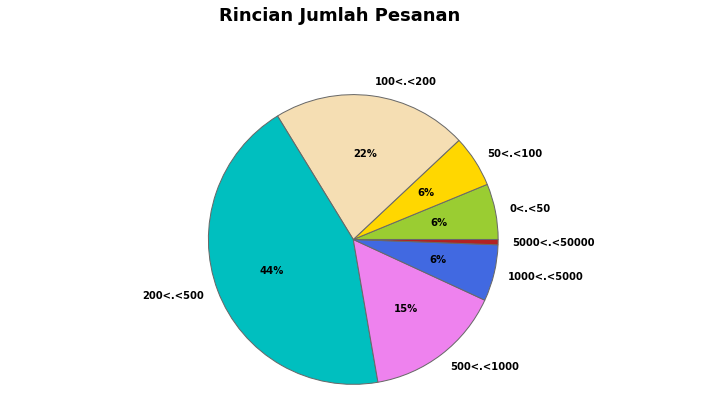

In [ ]:
#____________________
# Jumlah pembelian
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
# Representasi jumlah pembelian / jumlah        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Rincian Jumlah Pesanan", ha='center', fontsize = 18);